In [19]:
import os
from PIL import Image
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm

In [2]:
class CelebADataset(Dataset):
    def __init__(self, image_dir, attr_path, transform=None, selected_attrs=None):
        self.image_dir = image_dir
        self.attr_path = attr_path
        self.transform = transform

        df = pd.read_csv(attr_path, delim_whitespace=True, skiprows=1)
        df[df == -1] = 0  # convert -1/1 to 0/1
        self.attr_names = df.columns.tolist()
        self.image_names = df.index.tolist()

        if selected_attrs is not None:
            self.attr_indices = [self.attr_names.index(attr) for attr in selected_attrs]
        else:
            self.attr_indices = list(range(len(self.attr_names)))

        self.attrs = df.iloc[:, self.attr_indices].values.astype("float32")

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.attrs[idx])
        return image, label

In [3]:
transform = transforms.Compose(
    [
        transforms.CenterCrop(178),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x / 255.0),  # Normalize to [0, 1]
    ]
)

dataset = CelebADataset(
    image_dir="../../data/celeba/celeba/img_align_celeba",
    attr_path="../../data/celeba/celeba/list_attr_celeba.txt",
    transform=transform,
    selected_attrs=None,
)

dataloader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0
)

/tmp/ipykernel_55420/3591280984.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(attr_path, delim_whitespace=True, skiprows=1)


In [4]:
for images, labels in dataloader:
    print(images.shape)   # [128, 3, 64, 64]
    print(labels.shape)   # [128, 40]
    break

torch.Size([128, 3, 32, 32])
torch.Size([128, 40])


In [5]:
class Encoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(input_dim, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.relu = nn.ReLU()
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))

        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dim: int, output_dim: int, use_sigmoid: bool = False) -> None:
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128 * 4 * 4)

        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.deconv3 = nn.ConvTranspose2d(32, output_dim, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.use_sigmoid = use_sigmoid

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        x = self.fc(z)
        x = x.view(x.size(0), 128, 4, 4)

        x = self.relu(self.bn1(self.deconv1(x)))
        x = self.relu(self.bn2(self.deconv2(x)))
        x = self.deconv3(x)
        if self.use_sigmoid:
            x = self.sigmoid(x)
        return x

In [7]:
def reparameterize(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, beta: float = 2000, use_bce: bool = False) -> None:
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim, use_sigmoid=True)
        self.beta = beta
        self.use_bce = use_bce

    def get_loss(self, x: torch.Tensor) -> torch.Tensor:
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        x_recon = self.decoder(z)

        if self.use_bce:
            recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
        else:
            recon_loss = F.mse_loss(x_recon, x, reduction='sum')

        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + self.beta * kl_loss

In [24]:
model = VAE(input_dim=3, latent_dim=200, beta=1, use_bce=True)

epochs = 1
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (fc_mu): Linear(in_features=2048, out_features=200, bias=True)
    (fc_logvar): Linear(in_features=2048, out_features=200, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=200, out_features=2048, bias=True)
    (deconv1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (decon

In [25]:
def train(model: nn.Module, dataloader: DataLoader, optimizer: optim.Optimizer, epochs: int) -> None:
    losses = []
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)

        for images, _ in progress_bar:
            optimizer.zero_grad()
            loss = model.get_loss(images)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            losses.append(loss.item())
            avg_loss = total_loss / ((progress_bar.n + 1) * images.size(0))
            progress_bar.set_postfix(loss=avg_loss)
    
    return losses

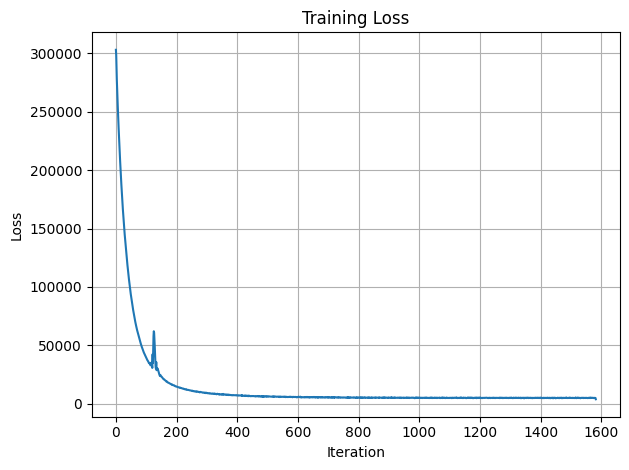

In [26]:
losses = train(model, dataloader, optimizer, epochs)

import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

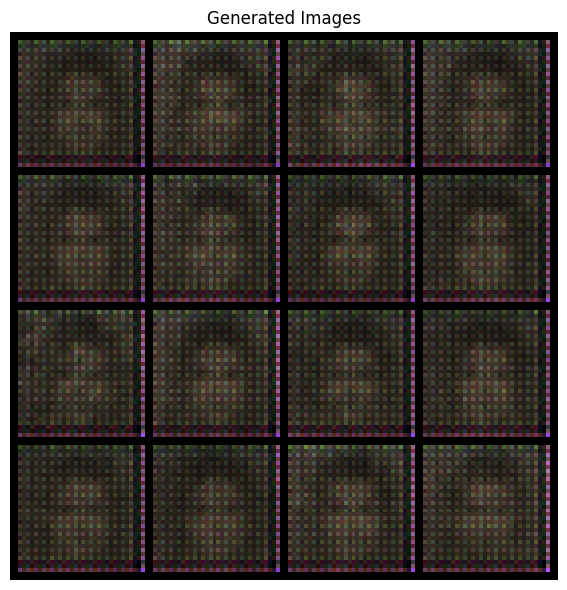

In [27]:
z = torch.randn(16, 200)  # Sample random latent vectors
with torch.no_grad():
    generated_images = model.decoder(z)

generated_images = generated_images.clamp(0, 1)  # Ensure pixel values are in [0, 1]
grid_img = torchvision.utils.make_grid(generated_images, nrow=4, normalize=True)

plt.figure(figsize=(6, 6))
plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.title('Generated Images')
plt.tight_layout()
plt.show()